# Time Series Prediction using Random Forest
### Helpful resources:  
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html  
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276  
- https://pythondata.com/forecasting-with-random-forests/  
- https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1  

For simplification, the prediction is currently only done on item 7798, 24, 15  
### Content
- Simple Exponential Smoothing  
- Holt Winter  
- Random Forest  

In [14]:
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [15]:
# import packages
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing, Holt

In [16]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
# load data
df_train = pd.read_csv('data/orders0206_train.csv', sep='|', parse_dates=['time'])
df_train_small = df_train[df_train["itemID"].isin([7798,24,15])]
display(df_train_small.head(3))
# df_test = pd.read_csv('data/orders0206_test.csv', sep='|', parse_dates=['time'])

# df_info = pd.read_csv('data/infos.csv', sep='|', index_col='itemID')
# df_items = pd.read_csv('data/items.csv', sep='|', index_col='itemID')
# product_prices = df_info['simulationPrice'].to_dict()

# df_train_joined = df_train.join(df_info, on='itemID').join(df_items, on='itemID')

,time,transactID,itemID,order,salesPrice
226,2018-01-01 10:36:22,2256999,7798,2,10.97
731,2018-01-01 12:52:49,2263392,7798,1,10.97
2319,2018-01-01 16:39:16,2272248,7798,1,10.97


In [18]:
# aggregate sales per day
df_train_small['date'] = [d.date() for d in df_train_small['time']]
df_aggregated = df_train_small.groupby(['itemID','date']).size().to_frame().reset_index()
df_aggregated = df_aggregated.rename(columns={0: "count"})

In [19]:
# add 0 sales for missing dates per itemID
for prod in df_aggregated.itemID.unique():
    s = df_aggregated.loc[df_aggregated['itemID'] == prod][["date","count"]]
    s = s.set_index("date")
    idx = pd.date_range(s.index.min(), 
                        s.index.max())
    s.index = pd.DatetimeIndex(s.index)
    s = s.reindex(idx, fill_value=0)
    if "df_timeseries" not in globals():
        s["itemID"] = prod
        df_timeseries = s
    else:
        s["itemID"] = prod
        df_timeseries = pd.concat([df_timeseries,s], ignore_index=False)
df_timeseries.head(3)

,count,itemID
2018-01-04,8,15
2018-01-05,0,15
2018-01-06,0,15


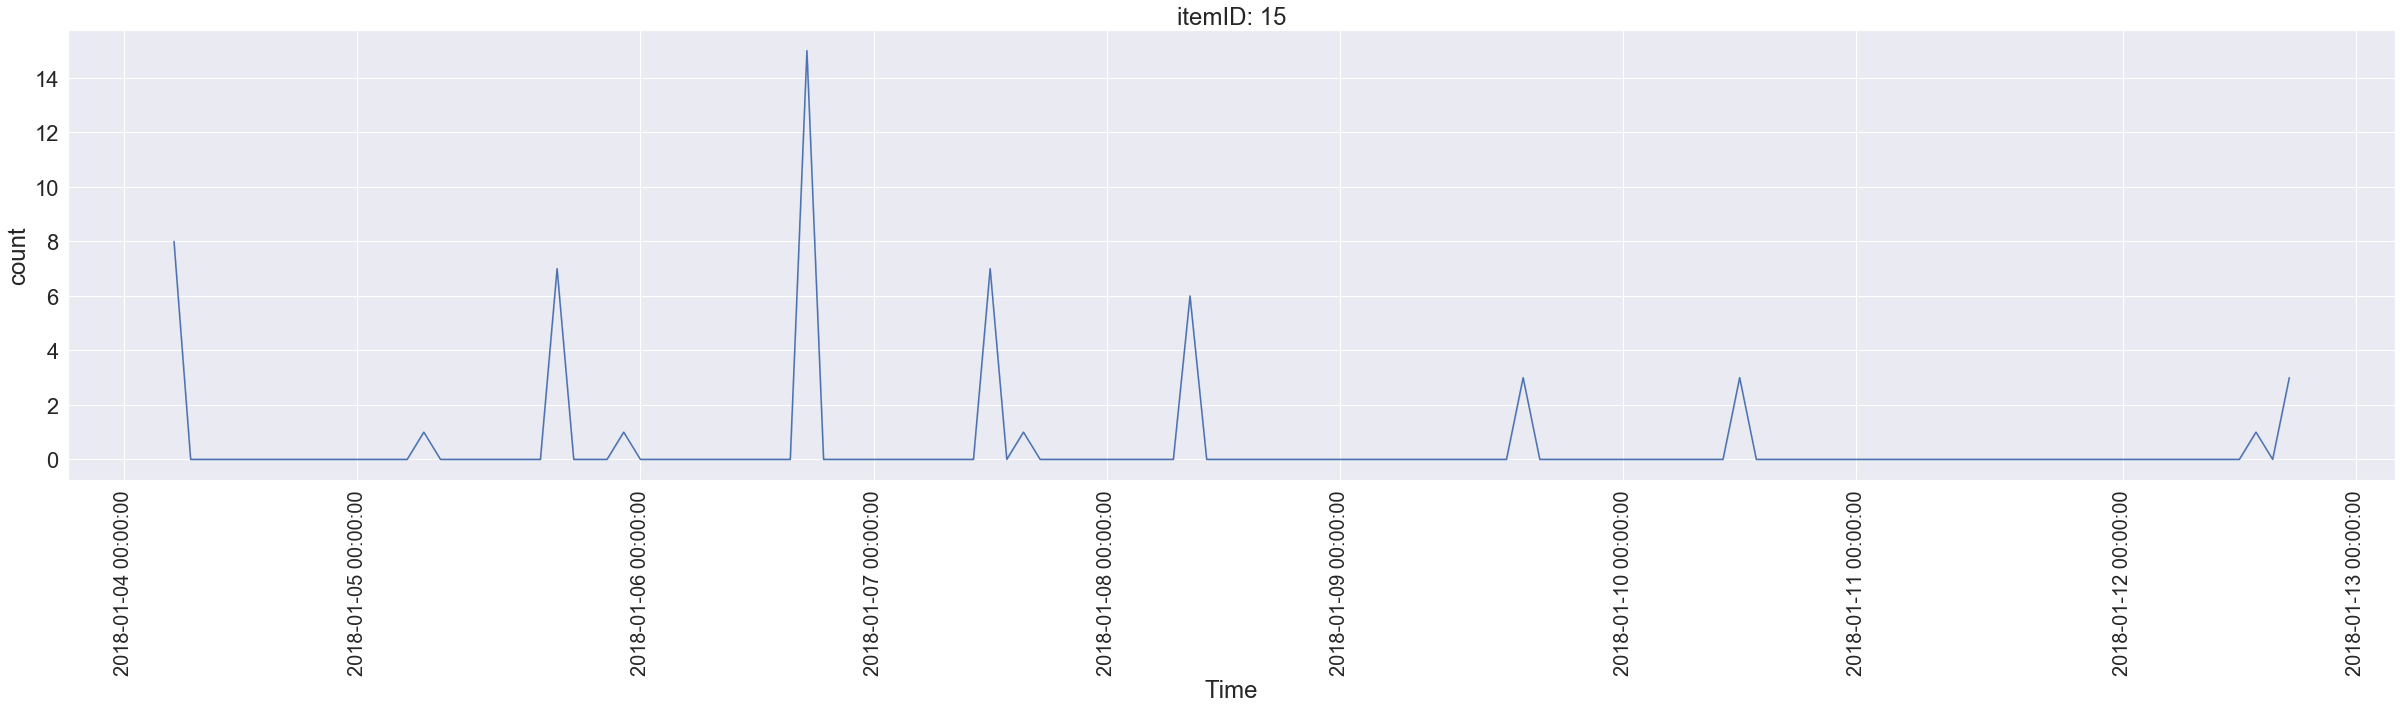

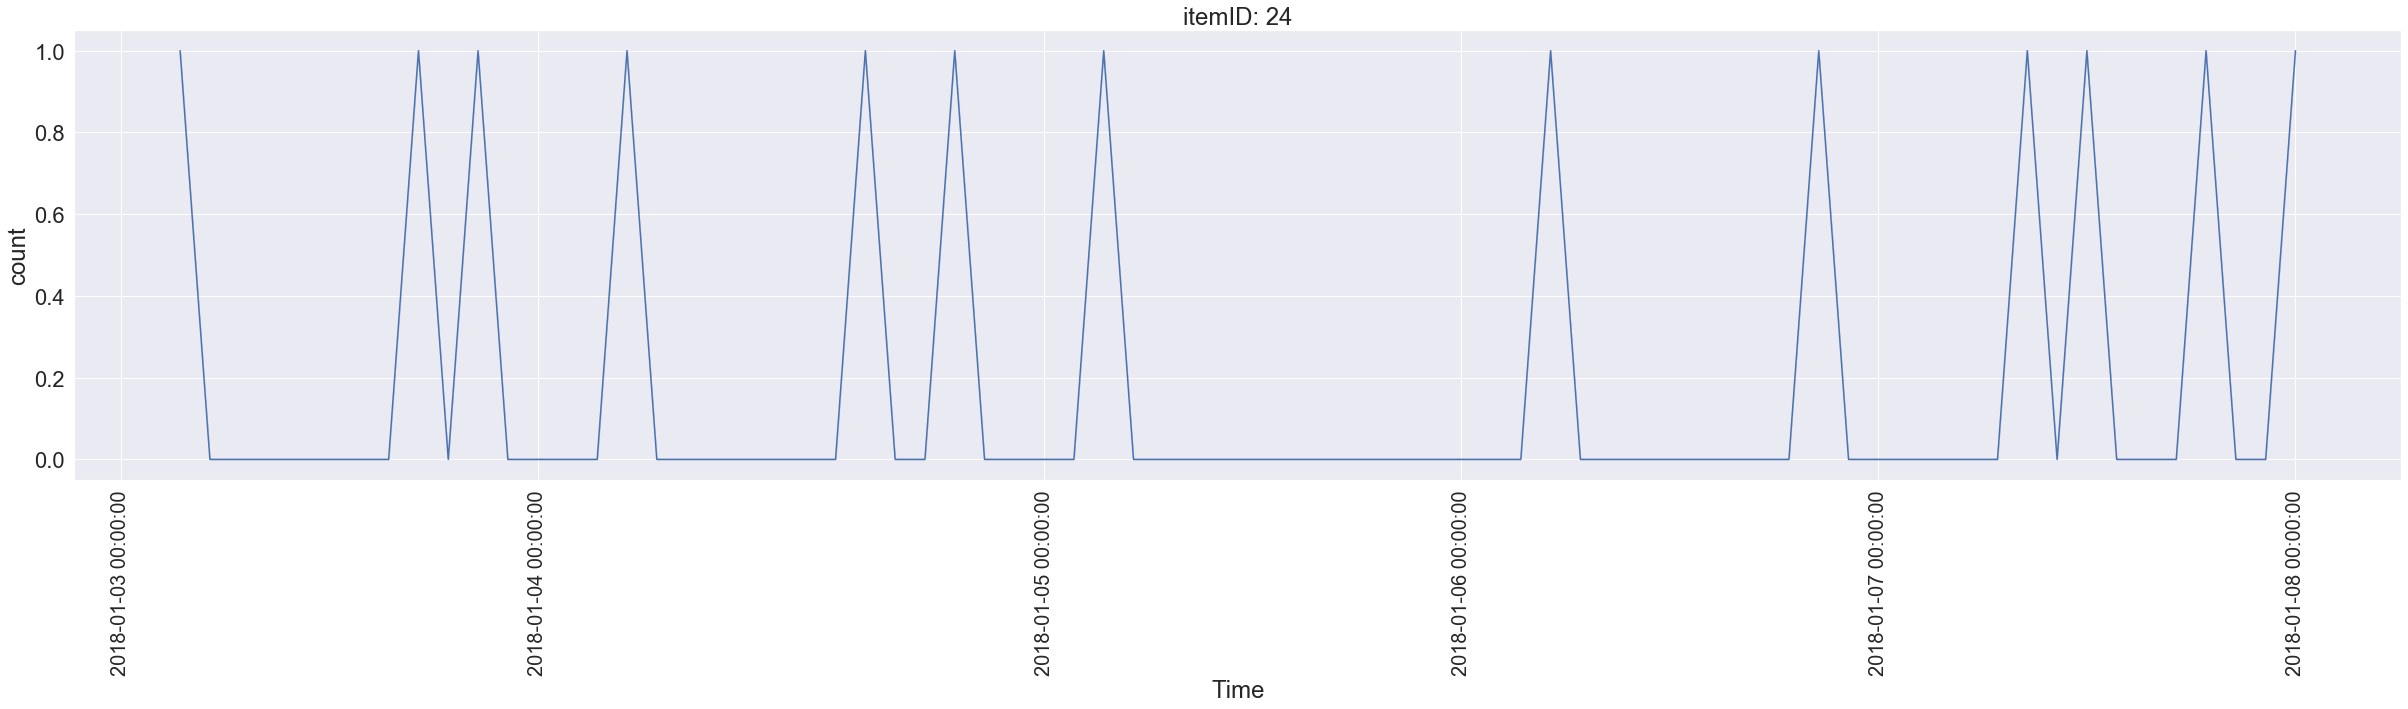

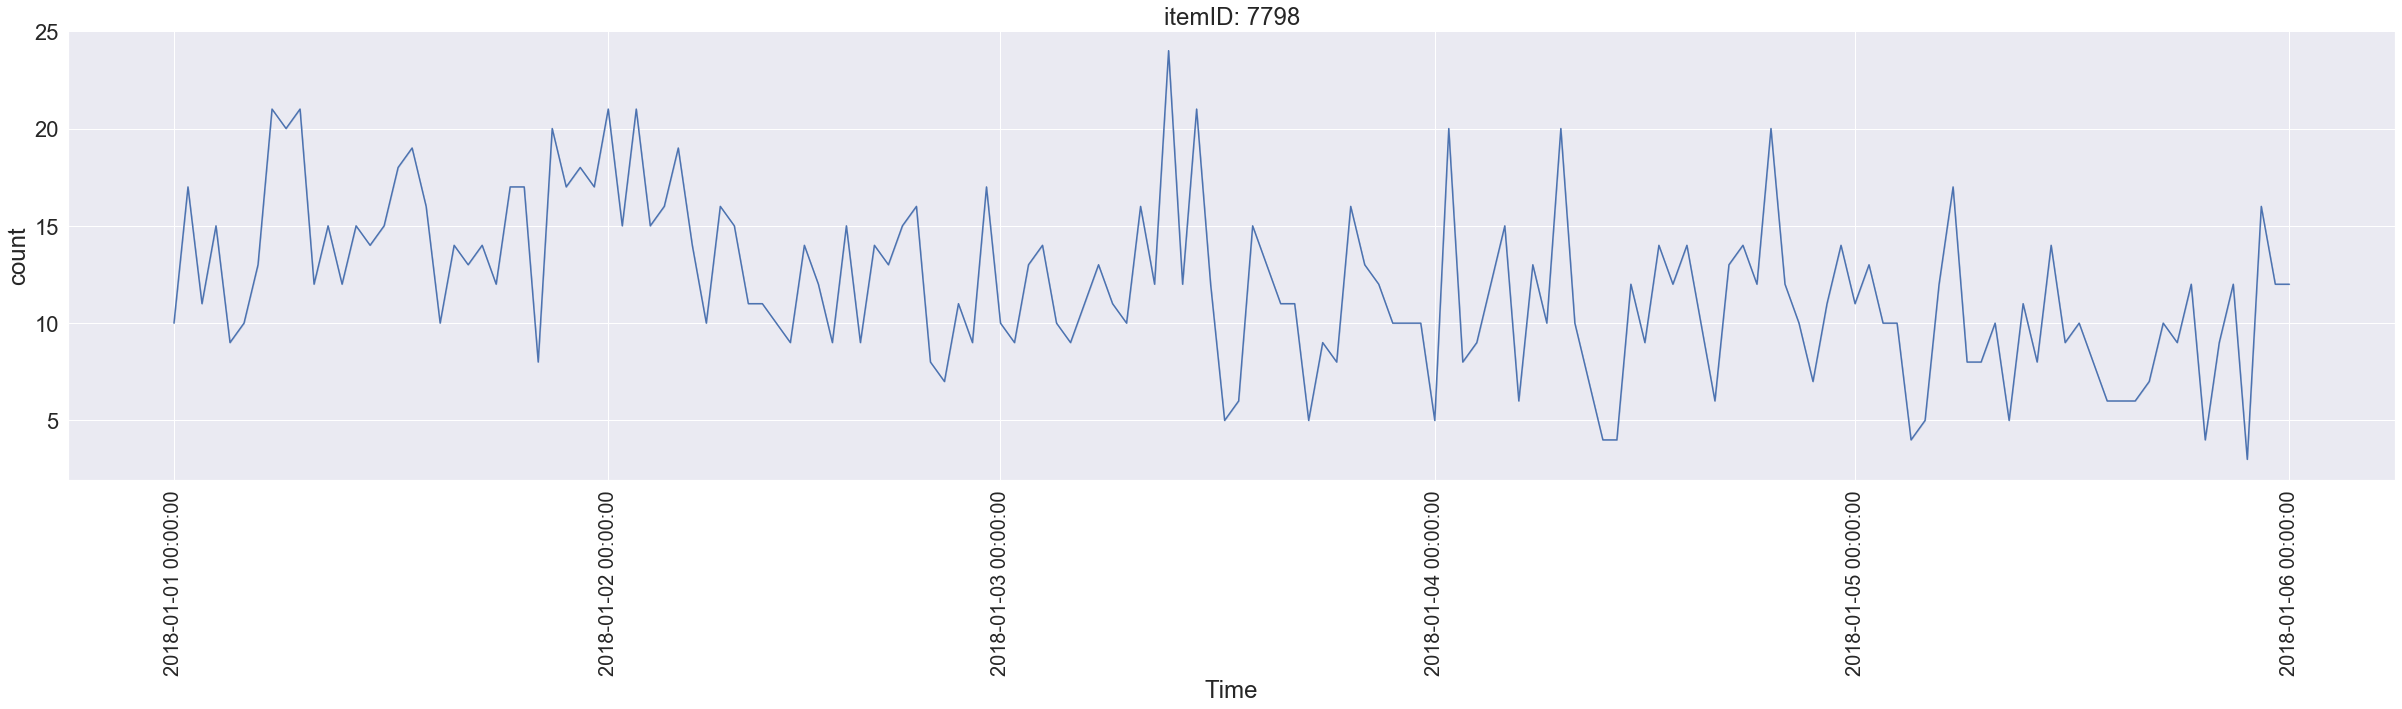

In [20]:
# plot sales of the products
sb.set(rc={'figure.figsize':(41.7,8.27)})
sb.set(font_scale=2)
for prod in df_timeseries.itemID.unique():
    lp = sb.lineplot(data=df_timeseries.loc[df_timeseries['itemID'] == prod], 
                      x=df_timeseries.loc[df_timeseries['itemID'] == prod].index, y='count')
    lp.set(title="itemID: " + str(prod))
    lp.set_xticklabels(df_timeseries.loc[df_timeseries['itemID'] == prod].index, rotation='vertical', fontsize=20)
    lp.set(xlabel='Time', ylabel='count')
    plt.show()

## Simple Exponential Smoothing
https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1

In [32]:
# # Simple Exponential Smoothing
# for prod in df_timeseries.itemID.unique():
#     a_data = df_timeseries.loc[df_timeseries['itemID'] == prod]['count']#.array()#.sort_values(by='index', ascending=True)['count'].array
#     fit1 = SimpleExpSmoothing(a_data).fit(smoothing_level=0.2,optimized=False)
#     fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
#     # plot
#     fcast1.plot(marker='o', color='blue', legend=True)
#     fit1.fittedvalues.plot(marker='o',  color='blue')



#     fit2 = SimpleExpSmoothing(a_data).fit(smoothing_level=0.6,optimized=False)
#     fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
#     # plot
#     fcast2.plot(marker='o', color='red', legend=True)
#     fit2.fittedvalues.plot(marker='o', color='red')


#     fit3 = SimpleExpSmoothing(a_data).fit()
#     fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
#     # plot
#     fcast3.plot(marker='o', color='green', legend=True)
#     fit3.fittedvalues.plot(marker='o', color='green')

#     plt.show()
    
#     print("itemID: " + str(prod))

ValueError: view limit minimum -36572.450000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36572.450000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 3002.4x595.44 with 1 Axes>

## Holt Winter
https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1

In [30]:
# for prod in df_timeseries.itemID.unique():
#     a_data = df_timeseries.loc[df_timeseries['itemID'] == prod]['count']#.array#.sort_values(by='index', ascending=True)['count'].array
#     # since data must be positive, add 0.0001 to all numbers
#     a_data = a_data + 0.001
#     fit1 = ExponentialSmoothing(a_data, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
#     fit2 = ExponentialSmoothing(a_data, seasonal_periods=4, trend='add', seasonal='mul').fit(use_boxcox=True)
#     fit3 = ExponentialSmoothing(a_data, seasonal_periods=4, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
#     fit4 = ExponentialSmoothing(a_data, seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
#     fit1.fittedvalues.plot(style='--', color='red')
#     fit2.fittedvalues.plot(style='--', color='green')

#     fit1.forecast(12).plot(style='--', marker='o', color='red', legend=True)
#     fit2.forecast(12).plot(style='--', marker='o', color='green', legend=True)

#     plt.show()
#     print("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality. \nitemID: " + str(prod))

## Random Forest
https://pythondata.com/forecasting-with-random-forests/  
Needs a format with feature + target.

In [25]:
def table2lags(table, max_lag, min_lag=0, separator='_'):
#     https://datascience.stackexchange.com/questions/24108/multiple-time-series-predictions-with-random-forests-in-python
    """ Given a dataframe, return a dataframe with different lags of all its columns """
    values=[]
    for i in range(min_lag, max_lag + 1):
        values.append(table.shift(i).copy())
        values[-1].columns = [c + separator + str(i) for c in table.columns]
    return pd.concat(values, axis=1)

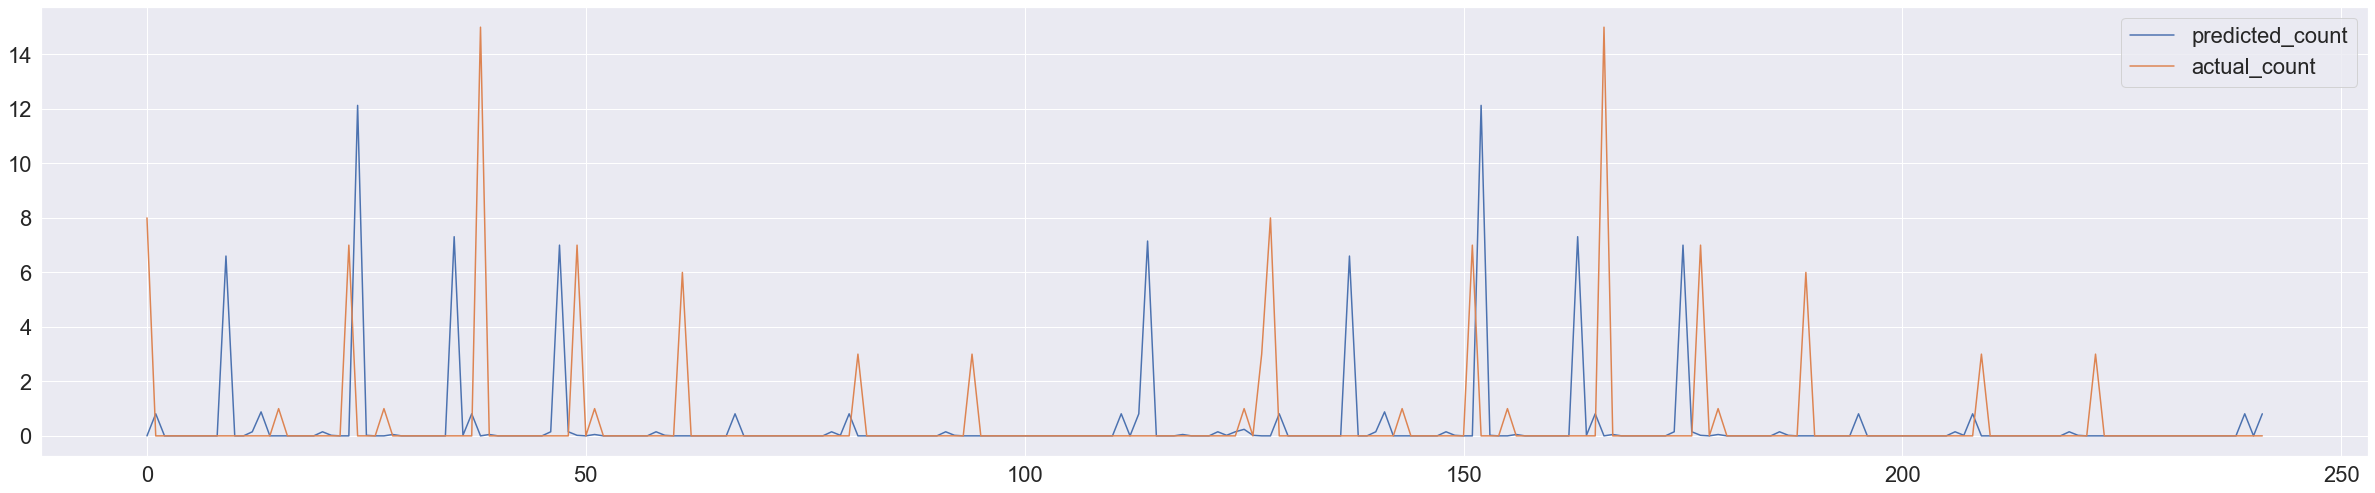

itemID: 15


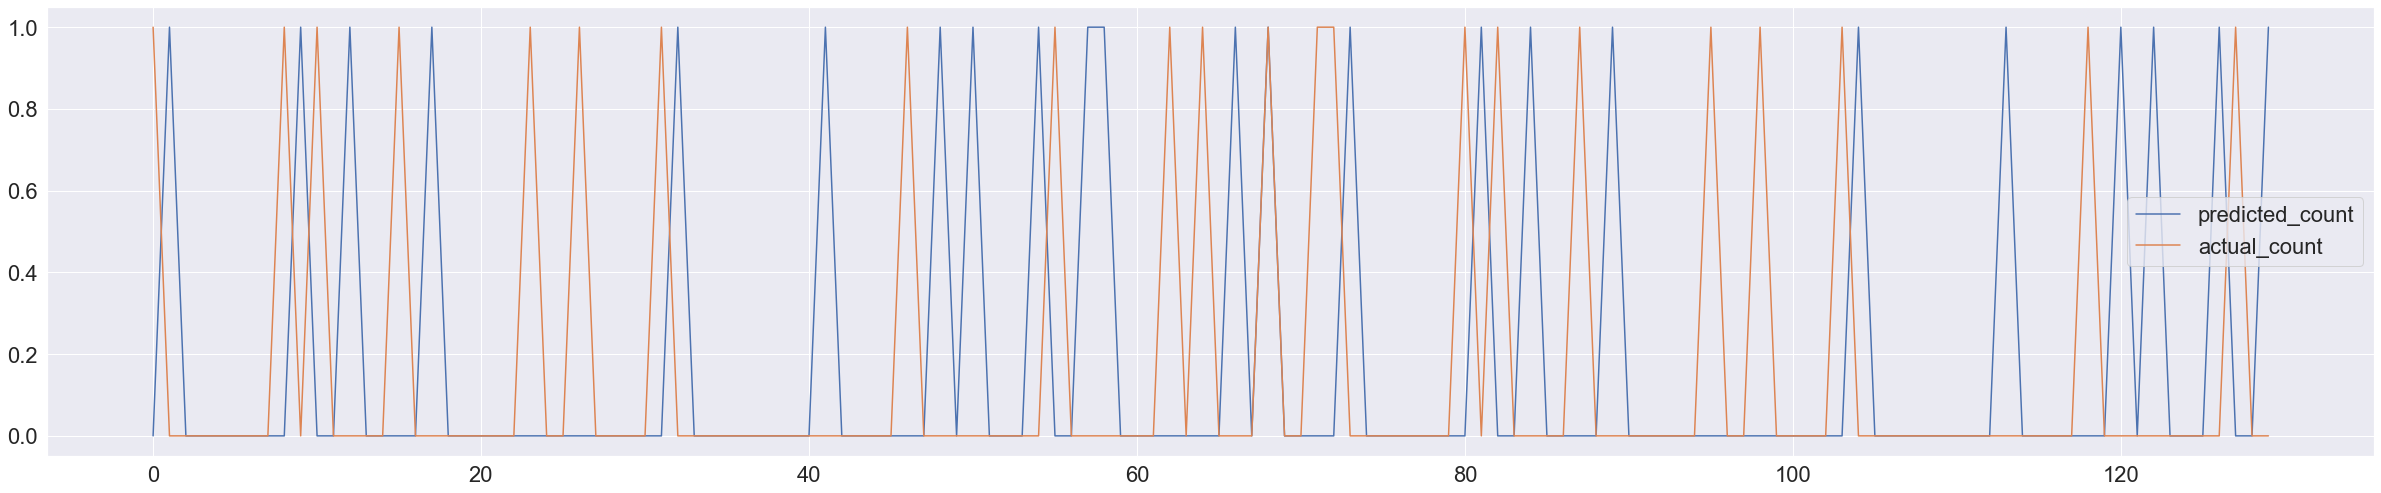

itemID: 24


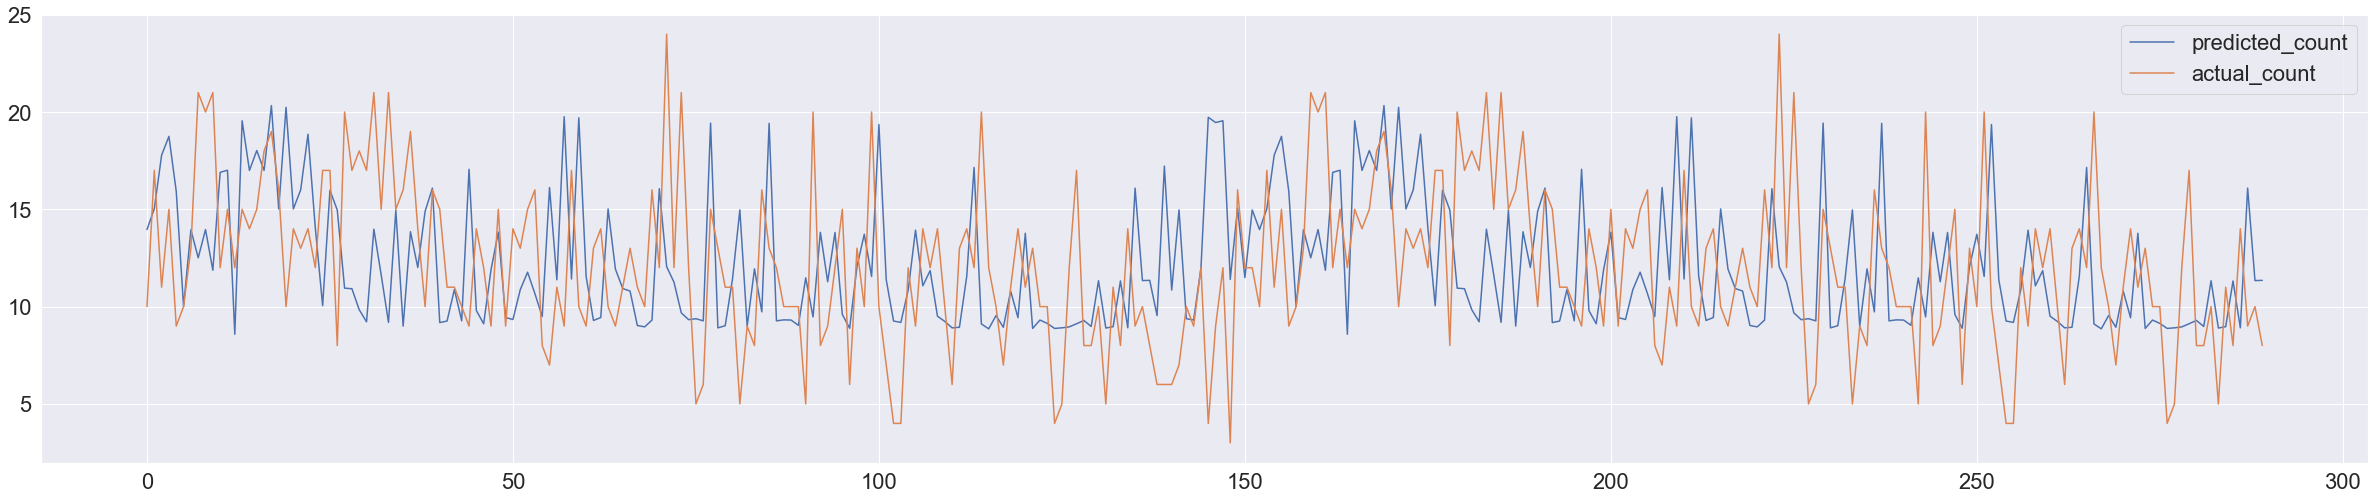

itemID: 7798


In [26]:
for prod in df_timeseries.itemID.unique():
    lag = 14
    
    # get lagged features
    features = table2lags(df_timeseries[df_timeseries['itemID'] == prod][['count']], lag)
#     display(features)
    
    # fit model
    rf = RandomForestRegressor().fit(features[lag:50], df_timeseries[df_timeseries['itemID'] == prod]['count'][lag:50])
    
    # predict
    train_predict = pd.DataFrame(rf.predict(features[lag:])).rename(columns={0:'predicted_count'})
    train_predict["actual_count"] = df_timeseries.loc[df_timeseries['itemID'] == prod].reset_index()["count"].tail(
        df_timeseries.loc[df_timeseries['itemID'] == prod].size-lag-50)
    
    # plot result
    train_predict.plot()
    plt.show()
    print("itemID: " + str(prod))
#     features.plot()